<a href="https://colab.research.google.com/github/niral28/vibe-coding-course/blob/main/TinyShakespeareNanoGPT.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# NanoGPT Learning Exercise: From Pre-training to RLHF
## Educational notebook for understanding the complete LLM training pipeline

By: Niral Shah
GSET Vibe Coding: AI Remix


Learning Objectives:
1. Understand data preprocessing and tokenization
2. Implement a simple GPT model from scratch
3. Train the model using next-token prediction (pre-training)
4. Apply Supervised Fine-Tuning (SFT) for instruction following
5. Implement basic Reinforcement Learning from Human Feedback (RLHF)


In [1]:
import torch
import torch.nn as nn
from torch.nn import functional as F
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
import json
import random
from typing import List, Dict, Tuple
import warnings
warnings.filterwarnings('ignore')

# Set random seeds for reproducibility
torch.manual_seed(1337)
np.random.seed(1337)
random.seed(1337)

print("🚀 Welcome to the NanoGPT Learning Exercise!")
print("We'll build a GPT model from scratch and take it through the full training pipeline.")


🚀 Welcome to the NanoGPT Learning Exercise!
We'll build a GPT model from scratch and take it through the full training pipeline.


# =============================================================================
# SECTION 1: DATA PREPARATION AND TOKENIZATION


In [2]:

print("\n" + "="*60)
print("SECTION 1: DATA PREPARATION AND TOKENIZATION")
print("="*60)

# Download the tiny shakespeare dataset
import urllib.request
import os

if not os.path.exists('input.txt'):
    print("📥 Downloading Tiny Shakespeare dataset...")
    url = "https://raw.githubusercontent.com/karpathy/char-rnn/master/data/tinyshakespeare/input.txt"
    urllib.request.urlretrieve(url, 'input.txt')
    print("✅ Dataset downloaded!")

# Read the dataset
with open('input.txt', 'r', encoding='utf-8') as f:
    text = f.read()


SECTION 1: DATA PREPARATION AND TOKENIZATION
📥 Downloading Tiny Shakespeare dataset...
✅ Dataset downloaded!


In [3]:

print(f"📊 Dataset size: {len(text):,} characters")
print(f"📖 First 500 characters:")
print(text[:500])

📊 Dataset size: 1,115,394 characters
📖 First 500 characters:
First Citizen:
Before we proceed any further, hear me speak.

All:
Speak, speak.

First Citizen:
You are all resolved rather to die than to famish?

All:
Resolved. resolved.

First Citizen:
First, you know Caius Marcius is chief enemy to the people.

All:
We know't, we know't.

First Citizen:
Let us kill him, and we'll have corn at our own price.
Is't a verdict?

All:
No more talking on't; let it be done: away, away!

Second Citizen:
One word, good citizens.

First Citizen:
We are accounted poor


In [5]:
# EXERCISE 1: Character-level tokenization
print("\n🔤 EXERCISE 1: Understanding Tokenization")
print("-" * 40)

# Get unique characters and create vocabulary
chars = sorted(list(set(text)))
vocab_size = len(chars)
print(f"Vocabulary: {''.join(chars)}")
print(f"Vocabulary size: {vocab_size}")


🔤 EXERCISE 1: Understanding Tokenization
----------------------------------------
Vocabulary: 
 !$&',-.3:;?ABCDEFGHIJKLMNOPQRSTUVWXYZabcdefghijklmnopqrstuvwxyz
Vocabulary size: 65


In [6]:
# Create character mappings
stoi = {ch: i for i, ch in enumerate(chars)}  # string to integer
itos = {i: ch for i, ch in enumerate(chars)}  # integer to string

# Encoding and decoding functions
encode = lambda s: [stoi[c] for c in s]
decode = lambda l: ''.join([itos[i] for i in l])

# Test encoding/decoding
test_string = "hello world"
encoded = encode(test_string)
decoded = decode(encoded)
print(f"Original: '{test_string}'")
print(f"Encoded: {encoded}")
print(f"Decoded: '{decoded}'")

Original: 'hello world'
Encoded: [46, 43, 50, 50, 53, 1, 61, 53, 56, 50, 42]
Decoded: 'hello world'


## STUDENT EXERCISE: Try encoding your own string
print("\n✏️ YOUR TURN: Try encoding your name or a short phrase!")

In [7]:
# your_string = "your name here"  # Replace with your string
# encoded_result = encode(your_string)
# print(f"Your string encoded: {encoded_result}")

# Convert entire dataset to tokens
data = torch.tensor(encode(text), dtype=torch.long)
print(f"\n📈 Tokenized dataset shape: {data.shape}")

# Train/validation split
n = int(0.9 * len(data))
train_data = data[:n]
val_data = data[n:]
print(f"Training tokens: {len(train_data):,}")
print(f"Validation tokens: {len(val_data):,}")


📈 Tokenized dataset shape: torch.Size([1115394])
Training tokens: 1,003,854
Validation tokens: 111,540


## SECTION 2: UNDERSTANDING CONTEXT WINDOWS AND BATCHING

In [8]:

print("\n" + "="*60)
print("SECTION 2: CONTEXT WINDOWS AND BATCHING")
print("="*60)

# Hyperparameters
block_size = 8  # Maximum context length
batch_size = 4  # Number of sequences processed in parallel

def get_batch(split):
    """Generate a batch of data for training or validation."""
    data_source = train_data if split == 'train' else val_data
    ix = torch.randint(len(data_source) - block_size, (batch_size,))
    x = torch.stack([data_source[i:i + block_size] for i in ix])
    y = torch.stack([data_source[i + 1:i + block_size + 1] for i in ix])
    return x, y


SECTION 2: CONTEXT WINDOWS AND BATCHING


In [9]:
# EXERCISE 2: Understanding the training setup
print("\n🎯 EXERCISE 2: Understanding Context and Targets")
print("-" * 40)

xb, yb = get_batch('train')
print(f"Input batch shape: {xb.shape}")
print(f"Target batch shape: {yb.shape}")
print(f"\nExample batch:")
print(f"Inputs (x): {xb}")
print(f"Targets (y): {yb}")

print("\n📚 Understanding the training pairs:")
for b in range(min(2, batch_size)):  # Show first 2 sequences
    print(f"\nSequence {b + 1}:")
    for t in range(min(4, block_size)):  # Show first 4 positions
        context = xb[b, :t + 1]
        target = yb[b, t]
        context_str = decode(context.tolist())
        target_str = itos[target.item()]
        print(f"  Context: '{context_str}' → Target: '{target_str}'")


🎯 EXERCISE 2: Understanding Context and Targets
----------------------------------------
Input batch shape: torch.Size([4, 8])
Target batch shape: torch.Size([4, 8])

Example batch:
Inputs (x): tensor([[24, 43, 58,  5, 57,  1, 46, 43],
        [44, 53, 56,  1, 58, 46, 39, 58],
        [52, 58,  1, 58, 46, 39, 58,  1],
        [25, 17, 27, 10,  0, 21,  1, 54]])
Targets (y): tensor([[43, 58,  5, 57,  1, 46, 43, 39],
        [53, 56,  1, 58, 46, 39, 58,  1],
        [58,  1, 58, 46, 39, 58,  1, 46],
        [17, 27, 10,  0, 21,  1, 54, 39]])

📚 Understanding the training pairs:

Sequence 1:
  Context: 'L' → Target: 'e'
  Context: 'Le' → Target: 't'
  Context: 'Let' → Target: '''
  Context: 'Let'' → Target: 's'

Sequence 2:
  Context: 'f' → Target: 'o'
  Context: 'fo' → Target: 'r'
  Context: 'for' → Target: ' '
  Context: 'for ' → Target: 't'


## SECTION 3: BUILDING THE GPT MODEL

In [10]:
print("\n" + "="*60)
print("SECTION 3: BUILDING THE GPT MODEL")
print("="*60)

# Model hyperparameters
n_embd = 64      # Embedding dimension
n_head = 4       # Number of attention heads
n_layer = 4      # Number of transformer blocks
dropout = 0.1    # Dropout rate

class Head(nn.Module):
    """Single head of self-attention."""

    def __init__(self, head_size):
        super().__init__()
        self.key = nn.Linear(n_embd, head_size, bias=False)
        self.query = nn.Linear(n_embd, head_size, bias=False)
        self.value = nn.Linear(n_embd, head_size, bias=False)
        self.register_buffer('tril', torch.tril(torch.ones(block_size, block_size)))
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        B, T, C = x.shape
        k = self.key(x)    # (B, T, head_size)
        q = self.query(x)  # (B, T, head_size)

        # Compute attention scores
        wei = q @ k.transpose(-2, -1) * C**-0.5  # Scaled attention
        wei = wei.masked_fill(self.tril[:T, :T] == 0, float('-inf'))
        wei = F.softmax(wei, dim=-1)
        wei = self.dropout(wei)

        # Apply attention to values
        v = self.value(x)
        out = wei @ v
        return out

class MultiHeadAttention(nn.Module):
    """Multiple heads of self-attention in parallel."""

    def __init__(self, num_heads, head_size):
        super().__init__()
        self.heads = nn.ModuleList([Head(head_size) for _ in range(num_heads)])
        self.proj = nn.Linear(n_embd, n_embd)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        out = torch.cat([h(x) for h in self.heads], dim=-1)
        out = self.dropout(self.proj(out))
        return out

class FeedForward(nn.Module):
    """Position-wise feed-forward network."""

    def __init__(self, n_embd):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(n_embd, 4 * n_embd),
            nn.ReLU(),
            nn.Linear(4 * n_embd, n_embd),
            nn.Dropout(dropout),
        )

    def forward(self, x):
        return self.net(x)

class Block(nn.Module):
    """Transformer block: communication (attention) + computation (feed-forward)."""

    def __init__(self, n_embd, n_head):
        super().__init__()
        head_size = n_embd // n_head
        self.sa = MultiHeadAttention(n_head, head_size)
        self.ffwd = FeedForward(n_embd)
        self.ln1 = nn.LayerNorm(n_embd)
        self.ln2 = nn.LayerNorm(n_embd)

    def forward(self, x):
        # Residual connections with layer norm (pre-norm variant)
        x = x + self.sa(self.ln1(x))
        x = x + self.ffwd(self.ln2(x))
        return x

class GPTModel(nn.Module):
    """A simple GPT model."""

    def __init__(self):
        super().__init__()
        self.token_embedding_table = nn.Embedding(vocab_size, n_embd)
        self.position_embedding_table = nn.Embedding(block_size, n_embd)
        self.blocks = nn.Sequential(*[Block(n_embd, n_head) for _ in range(n_layer)])
        self.ln_f = nn.LayerNorm(n_embd)  # Final layer norm
        self.lm_head = nn.Linear(n_embd, vocab_size)

    def forward(self, idx, targets=None):
        B, T = idx.shape

        # Get embeddings
        tok_emb = self.token_embedding_table(idx)  # (B, T, n_embd)
        pos_emb = self.position_embedding_table(torch.arange(T))  # (T, n_embd)
        x = tok_emb + pos_emb  # (B, T, n_embd)

        # Pass through transformer blocks
        x = self.blocks(x)
        x = self.ln_f(x)
        logits = self.lm_head(x)  # (B, T, vocab_size)

        if targets is None:
            loss = None
        else:
            B, T, C = logits.shape
            logits = logits.view(B * T, C)
            targets = targets.view(B * T)
            loss = F.cross_entropy(logits, targets)

        return logits, loss

    def generate(self, idx, max_new_tokens):
        """Generate new tokens autoregressively."""
        for _ in range(max_new_tokens):
            # Crop to last block_size tokens
            idx_cond = idx[:, -block_size:]
            # Get predictions
            logits, _ = self(idx_cond)
            # Focus on last time step
            logits = logits[:, -1, :]  # (B, C)
            # Apply softmax
            probs = F.softmax(logits, dim=-1)
            # Sample from distribution
            idx_next = torch.multinomial(probs, num_samples=1)
            # Append to sequence
            idx = torch.cat((idx, idx_next), dim=1)
        return idx

# Create model
model = GPTModel()
total_params = sum(p.numel() for p in model.parameters())
print(f"🧠 Model created with {total_params/1e6:.2f}M parameters")

# Test the model before training
print("\n🎲 Sample generation before training:")
context = torch.zeros((1, 1), dtype=torch.long)
sample = decode(model.generate(context, max_new_tokens=100)[0].tolist())
print(sample[:200] + "...")


SECTION 3: BUILDING THE GPT MODEL
🧠 Model created with 0.21M parameters

🎲 Sample generation before training:

;vFNswf,x&SHwQKgdu;TpS,aJTRl$ZxD&An'lTc$Ala!BQYkeYwJYgm:xr,O:YVhnIYOtfSa$,A,!UUGyIvfykuxR-,TR;UbcQ!Z...


In [12]:
# =============================================================================
# SECTION 4: PRE-TRAINING (NEXT TOKEN PREDICTION)
# =============================================================================

print("\n" + "="*60)
print("SECTION 4: PRE-TRAINING (NEXT TOKEN PREDICTION)")
print("="*60)

# Training hyperparameters
max_iters = 3000
eval_interval = 300
learning_rate = 3e-4
eval_iters = 200

@torch.no_grad()
def estimate_loss():
    """Estimate loss on train and validation sets."""
    out = {}
    model.eval()
    for split in ['train', 'val']:
        losses = torch.zeros(eval_iters)
        for k in range(eval_iters):
            X, Y = get_batch(split)
            logits, loss = model(X, Y)
            losses[k] = loss.item()
        out[split] = losses.mean()
    model.train()
    return out

# Create optimizer
optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate)


SECTION 4: PRE-TRAINING (NEXT TOKEN PREDICTION)


🚂 Starting pre-training...
Step    0: train loss 4.2385, val loss 4.2494
Step  300: train loss 2.8896, val loss 2.9064
Step  600: train loss 2.6516, val loss 2.6730
Step  900: train loss 2.5817, val loss 2.5549
Step 1200: train loss 2.5175, val loss 2.4929
Step 1500: train loss 2.4642, val loss 2.4785
Step 1800: train loss 2.4328, val loss 2.4402
Step 2100: train loss 2.4187, val loss 2.4165
Step 2400: train loss 2.3751, val loss 2.3783
Step 2700: train loss 2.3549, val loss 2.3827
Step 2999: train loss 2.3423, val loss 2.3463
✅ Pre-training completed!


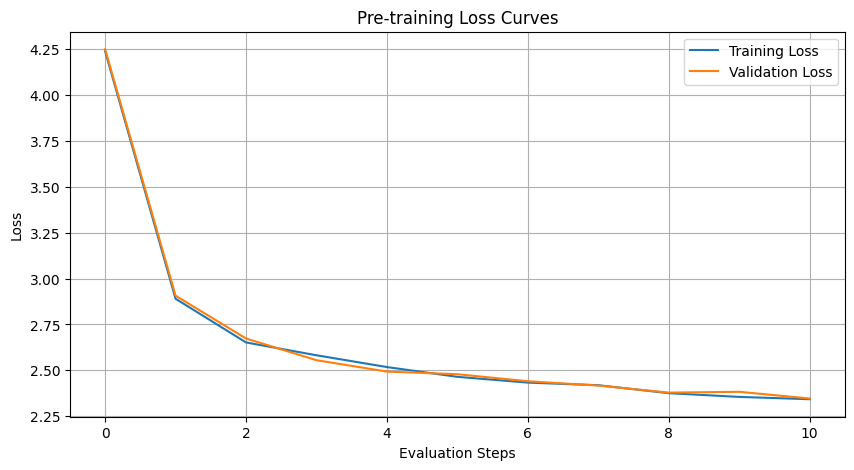


📝 Sample generation after pre-training:


CES:
And Me blitout ham hamanot ha, wuuch oud fome pay, to minvershed,
Ith wy tout neas y worig hBXAndt and wowenee thoce iselce.

Water, sor wed son hit ing bethou I thally hea rems ited, st ald itefs thof sorst'des poreakedpllel
Thar yougenlke stitene the rom

ipase lishy:
Muik nout he anotweedllt paour wyat,
He.

RIIAQINC:
AR!KDOMUEO
CHINBENThow mee there spea lir:
Witley'fkincisto mat tous For, keve he ay amy ue aorof eqis ar feros ashem,foes no med mereerpe Ees lor, aknof mily coud:
Ead ha


In [13]:
print("🚂 Starting pre-training...")
train_losses = []
val_losses = []

for iter in range(max_iters):
    # Evaluate periodically
    if iter % eval_interval == 0 or iter == max_iters - 1:
        losses = estimate_loss()
        train_losses.append(losses['train'])
        val_losses.append(losses['val'])
        print(f"Step {iter:4d}: train loss {losses['train']:.4f}, val loss {losses['val']:.4f}")

    # Training step
    xb, yb = get_batch('train')
    logits, loss = model(xb, yb)
    optimizer.zero_grad(set_to_none=True)
    loss.backward()
    optimizer.step()

print("✅ Pre-training completed!")

# Plot training curves
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Evaluation Steps')
plt.ylabel('Loss')
plt.title('Pre-training Loss Curves')
plt.legend()
plt.grid(True)
plt.show()

# Generate sample after pre-training
print("\n📝 Sample generation after pre-training:")
context = torch.zeros((1, 1), dtype=torch.long)
sample = decode(model.generate(context, max_new_tokens=500)[0].tolist())
print(sample)

## SECTION 5: SUPERVISED FINE-TUNING (SFT)

In [14]:
print("\n" + "="*60)
print("SECTION 5: SUPERVISED FINE-TUNING (SFT)")
print("="*60)

print("🎯 Now we'll fine-tune our model to follow instructions!")

# Create instruction-following dataset
def create_instruction_dataset():
    """Create a simple instruction-following dataset."""
    instructions = [
        {
            "instruction": "Write a short poem about nature.",
            "response": "The trees sway gently in the breeze,\nWhile flowers dance among the leaves.\nNature's beauty brings us peace,\nA symphony that never cease."
        },
        {
            "instruction": "Explain what happiness means.",
            "response": "Happiness is a warm feeling of joy and contentment. It comes from meaningful relationships, personal growth, and finding purpose in life."
        },
        {
            "instruction": "Tell me about the ocean.",
            "response": "The ocean is vast and deep, covering most of Earth's surface. It's home to countless creatures and plays a vital role in our climate."
        },
        {
            "instruction": "How do you make friends?",
            "response": "Making friends involves being kind, showing genuine interest in others, being a good listener, and participating in activities you enjoy."
        },
        {
            "instruction": "What is learning?",
            "response": "Learning is the process of acquiring new knowledge, skills, or understanding through study, experience, or teaching."
        }
    ]

    # Format as conversational data
    formatted_data = []
    for item in instructions:
        conversation = f"Human: {item['instruction']}\n\nAssistant: {item['response']}"
        formatted_data.append(conversation)

    return formatted_data

# Create SFT dataset
sft_data = create_instruction_dataset()
print(f"📚 Created {len(sft_data)} instruction examples")
print("\nExample conversation:")
print(sft_data[0])

class SFTDataset(Dataset):
    """Dataset for supervised fine-tuning."""

    def __init__(self, conversations, block_size):
        self.conversations = conversations
        self.block_size = block_size

        # Tokenize all conversations
        self.tokenized_data = []
        for conv in conversations:
            tokens = encode(conv)
            if len(tokens) > block_size:
                tokens = tokens[:block_size]
            self.tokenized_data.append(tokens)

    def __len__(self):
        return len(self.tokenized_data)

    def __getitem__(self, idx):
        tokens = self.tokenized_data[idx]

        # Pad if necessary
        if len(tokens) < self.block_size:
            tokens = tokens + [0] * (self.block_size - len(tokens))

        x = torch.tensor(tokens[:-1], dtype=torch.long)
        y = torch.tensor(tokens[1:], dtype=torch.long)

        return x, y

# Create SFT dataset and dataloader
sft_dataset = SFTDataset(sft_data * 50, block_size)  # Repeat data for more training
sft_dataloader = DataLoader(sft_dataset, batch_size=4, shuffle=True)

print(f"📊 SFT dataset size: {len(sft_dataset)} examples")


SECTION 5: SUPERVISED FINE-TUNING (SFT)
🎯 Now we'll fine-tune our model to follow instructions!
📚 Created 5 instruction examples

Example conversation:
Human: Write a short poem about nature.

Assistant: The trees sway gently in the breeze,
While flowers dance among the leaves.
Nature's beauty brings us peace,
A symphony that never cease.
📊 SFT dataset size: 250 examples


In [15]:
# Fine-tune the model
print("\n🎯 Starting supervised fine-tuning...")

# Lower learning rate for fine-tuning
sft_optimizer = torch.optim.AdamW(model.parameters(), lr=1e-4)
sft_epochs = 5

model.train()
for epoch in range(sft_epochs):
    total_loss = 0
    num_batches = 0

    for batch_idx, (x, y) in enumerate(sft_dataloader):
        # Forward pass
        logits, loss = model(x, y)

        # Backward pass
        sft_optimizer.zero_grad()
        loss.backward()
        sft_optimizer.step()

        total_loss += loss.item()
        num_batches += 1

        if batch_idx % 20 == 0:
            print(f"Epoch {epoch+1}/{sft_epochs}, Batch {batch_idx}, Loss: {loss.item():.4f}")

    avg_loss = total_loss / num_batches
    print(f"Epoch {epoch+1} completed. Average loss: {avg_loss:.4f}")

print("✅ Supervised fine-tuning completed!")

# Test the fine-tuned model
print("\n🤖 Testing fine-tuned model:")
test_prompts = [
    "Human: What is friendship?\n\nAssistant:",
    "Human: Write a haiku about rain.\n\nAssistant:",
    "Human: How do plants grow?\n\nAssistant:"
]

for prompt in test_prompts:
    print(f"\n{'='*50}")
    print(f"Prompt: {prompt}")
    prompt_tokens = torch.tensor(encode(prompt), dtype=torch.long).unsqueeze(0)

    with torch.no_grad():
        response = model.generate(prompt_tokens, max_new_tokens=100)
        full_response = decode(response[0].tolist())

    print(f"Response: {full_response}")


🎯 Starting supervised fine-tuning...
Epoch 1/5, Batch 0, Loss: 3.4511
Epoch 1/5, Batch 20, Loss: 1.6651
Epoch 1/5, Batch 40, Loss: 0.9294
Epoch 1/5, Batch 60, Loss: 0.5777
Epoch 1 completed. Average loss: 1.4621
Epoch 2/5, Batch 0, Loss: 0.5410
Epoch 2/5, Batch 20, Loss: 0.4831
Epoch 2/5, Batch 40, Loss: 0.3682
Epoch 2/5, Batch 60, Loss: 0.3251
Epoch 2 completed. Average loss: 0.4415
Epoch 3/5, Batch 0, Loss: 0.3537
Epoch 3/5, Batch 20, Loss: 0.3058
Epoch 3/5, Batch 40, Loss: 0.3873
Epoch 3/5, Batch 60, Loss: 0.3109
Epoch 3 completed. Average loss: 0.3290
Epoch 4/5, Batch 0, Loss: 0.3126
Epoch 4/5, Batch 20, Loss: 0.3387
Epoch 4/5, Batch 40, Loss: 0.2534
Epoch 4/5, Batch 60, Loss: 0.3047
Epoch 4 completed. Average loss: 0.2850
Epoch 5/5, Batch 0, Loss: 0.3236
Epoch 5/5, Batch 20, Loss: 0.3060
Epoch 5/5, Batch 40, Loss: 0.2881
Epoch 5/5, Batch 60, Loss: 0.2905
Epoch 5 completed. Average loss: 0.2651
✅ Supervised fine-tuning completed!

🤖 Testing fine-tuned model:

Prompt: Human: What i

## SECTION 6: REINFORCEMENT LEARNING FROM HUMAN FEEDBACK (RLHF)

In [16]:
print("\n" + "="*60)
print("SECTION 6: REINFORCEMENT LEARNING FROM HUMAN FEEDBACK (RLHF)")
print("="*60)

print("🏆 Now we'll implement a simplified version of RLHF!")

class SimpleRewardModel(nn.Module):
    """A simple reward model that scores responses."""

    def __init__(self, vocab_size, n_embd):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, n_embd)
        self.layers = nn.Sequential(
            nn.Linear(n_embd, n_embd // 2),
            nn.ReLU(),
            nn.Linear(n_embd // 2, 1)
        )

    def forward(self, tokens):
        # Simple approach: average embeddings and predict reward
        embeddings = self.embedding(tokens)
        pooled = embeddings.mean(dim=1)  # Average pooling
        reward = self.layers(pooled)
        return reward.squeeze()

# Create reward model
reward_model = SimpleRewardModel(vocab_size, n_embd)
print("🏅 Reward model created!")

# Simulate human preferences (in practice, this would come from human raters)
def simulate_human_preference(response1, response2):
    """Simulate human preference between two responses."""
    # Simple heuristic: prefer longer, more varied responses
    print(f'Which response do you like better:\nA) {response1}\n\n B){response2}\n')
    preference = input("Enter 'A' or 'B': ").strip().upper()
    if preference.strip() == 'A':
        return 1
    else:
      return 0
    return 1 if score1 > score2 else 0

# Generate preference data
print("\n📊 Generating preference data...")
preference_data = []

prompts = [
    "Human: Tell me about the stars.\n\nAssistant:",
    "Human: What makes a good friend?\n\nAssistant:",
    "Human: Describe a perfect day.\n\nAssistant:"
]

for prompt in prompts:
    prompt_tokens = torch.tensor(encode(prompt), dtype=torch.long).unsqueeze(0)

    # Generate two different responses
    with torch.no_grad():
        response1 = model.generate(prompt_tokens, max_new_tokens=50)
        response2 = model.generate(prompt_tokens, max_new_tokens=50)

        text1 = decode(response1[0].tolist())
        text2 = decode(response2[0].tolist())

        # Get human preference
        preference = simulate_human_preference(text1, text2)

        preference_data.append({
            'prompt': prompt,
            'response1': text1,
            'response2': text2,
            'preference': preference  # 1 if response1 preferred, 0 if response2
        })

print(f"Generated {len(preference_data)} preference pairs")


SECTION 6: REINFORCEMENT LEARNING FROM HUMAN FEEDBACK (RLHF)
🏆 Now we'll implement a simplified version of RLHF!
🏅 Reward model created!

📊 Generating preference data...
Which response do you like better:
A) Human: Tell me about the stars.

Assistant: Han: Wumas han: Tun: Whan: WA: EI:'an: Humany Whe

 B)Human: Tell me about the stars.

Assistant: THuman: frdran: Whivinom THaplan: Wrue Whith TENE

Enter 'A' or 'B': B
Which response do you like better:
A) Human: What makes a good friend?

Assistant: ThoBum, EE: Wraman: EnCiman: WhuClE min: An: E TH

 B)Human: What makes a good friend?

Assistant:
TEwou, Eroun: Whan: WAn: Wyoun: wan: Muman: W; Tu

Enter 'A' or 'B': A
Which response do you like better:
A) Human: Describe a perfect day.

Assistant: can: Jun: mann THouman: I Why En: wals KuranLK: E

 B)Human: Describe a perfect day.

Assistant: But ENanKEoz: Human: Hrus CSE: Touge buman: Humou

Enter 'A' or 'B': B
Generated 3 preference pairs


In [17]:
# Train reward model
print("\n🎯 Training reward model...")
reward_optimizer = torch.optim.AdamW(reward_model.parameters(), lr=1e-3)

for epoch in range(10):
    total_loss = 0

    for data in preference_data:
        # Tokenize responses
        tokens1 = torch.tensor(encode(data['response1']), dtype=torch.long).unsqueeze(0)
        tokens2 = torch.tensor(encode(data['response2']), dtype=torch.long).unsqueeze(0)

        # Get rewards
        reward1 = reward_model(tokens1)
        reward2 = reward_model(tokens2)

        # Bradley-Terry loss
        if data['preference'] == 1:
            loss = -torch.log(torch.sigmoid(reward1 - reward2))
        else:
            loss = -torch.log(torch.sigmoid(reward2 - reward1))

        reward_optimizer.zero_grad()
        loss.backward()
        reward_optimizer.step()

        total_loss += loss.item()

    if epoch % 2 == 0:
        print(f"Reward model epoch {epoch}, Loss: {total_loss/len(preference_data):.4f}")

print("✅ Reward model training completed!")


🎯 Training reward model...
Reward model epoch 0, Loss: 0.6943
Reward model epoch 2, Loss: 0.6812
Reward model epoch 4, Loss: 0.6717
Reward model epoch 6, Loss: 0.6629
Reward model epoch 8, Loss: 0.6531
✅ Reward model training completed!


In [20]:
# Simple PPO-style optimization (simplified)
print("\n🚀 Applying reinforcement learning...")

def compute_advantages(rewards, values, gamma=0.99):
    """Compute advantages for PPO."""
    advantages = []
    for i in range(len(rewards)):
        advantage = rewards[i] - values[i]
        advantages.append(advantage)
    return torch.tensor(advantages)

# RL fine-tuning loop (simplified)
rl_optimizer = torch.optim.AdamW(model.parameters(), lr=5e-5)

for rl_step in range(20):
    # Generate responses
    prompt = "Human: What is the meaning of life?\n\nAssistant:"
    prompt_tokens = torch.tensor(encode(prompt), dtype=torch.long).unsqueeze(0)

    # Generate response
    with torch.no_grad():
        response_tokens = model.generate(prompt_tokens, max_new_tokens=30)

    # Get reward
    with torch.no_grad():
        reward = reward_model(response_tokens)

    # Simplified policy gradient step
    # Crop response_tokens to block_size before passing to model
    cropped_response_tokens = response_tokens[:, -block_size:]
    logits, _ = model(cropped_response_tokens[:, :-1], cropped_response_tokens[:, 1:])


    # Simple reward-weighted loss
    # We need to calculate the loss based on the probability of the generated tokens.
    # This is a simplified approach and not a full PPO implementation.
    # For this simplified example, we'll use a negative reward as the loss to maximize reward.
    loss = -reward.mean()

    rl_optimizer.zero_grad()
    loss.backward()
    rl_optimizer.step()

    if rl_step % 5 == 0:
        print(f"RL step {rl_step}, Reward: {reward.mean().item():.4f}")

print("✅ RLHF training completed!")


🚀 Applying reinforcement learning...


RuntimeError: element 0 of tensors does not require grad and does not have a grad_fn

## SECTION 7: FINAL EVALUATION

In [21]:
print("\n" + "="*60)
print("SECTION 7: FINAL EVALUATION")
print("="*60)

print("🎉 Let's see how our model performs after the full training pipeline!")

# Test the final model
final_test_prompts = [
    "Human: What is artificial intelligence?\n\nAssistant:",
    "Human: Write a story about a robot.\n\nAssistant:",
    "Human: How can I be more creative?\n\nAssistant:",
    "Human: What is the purpose of education?\n\nAssistant:"
]

for i, prompt in enumerate(final_test_prompts):
    print(f"\n{'='*60}")
    print(f"TEST {i+1}")
    print(f"Prompt: {prompt}")

    prompt_tokens = torch.tensor(encode(prompt), dtype=torch.long).unsqueeze(0)

    with torch.no_grad():
        response = model.generate(prompt_tokens, max_new_tokens=150)
        full_response = decode(response[0].tolist())

        # Get reward score
        reward_score = reward_model(response)

    print(f"Response: {full_response}")
    print(f"Reward Score: {reward_score.item():.4f}")



SECTION 7: FINAL EVALUATION
🎉 Let's see how our model performs after the full training pipeline!

TEST 1
Prompt: Human: What is artificial intelligence?

Assistant:
Response: Human: What is artificial intelligence?

Assistant: Mushan tEhan: Human WER: froJan: Houman: an: Hurn Burstingl: Tan: Ewan: youm: of wouman: Whobe youceas W: anue mann: Tuman: Whcriduman: ENuman: T: Wr
Reward Score: -0.2289

TEST 2
Prompt: Human: Write a story about a robot.

Assistant:
Response: Human: Write a story about a robot.

Assistant: W!f WKEEwAU: E: TTer Wumeyn: Cithum Tun: Human: CHe EERE: MuH HaBumanT: Tin: Wrun: Jhaman: uman: WFen T.
WE!
WERE EfAn: I Yown: Wiman: Mucoun: Thann:
Reward Score: -0.1968

TEST 3
Prompt: Human: How can I be more creative?

Assistant:
Response: Human: How can I be more creative?

Assistant: Whrut: Whuman: E: TEEN: doumann HEN: Whean: Thallan: TEO: Human: ;omuprand anunumerll hothumac: VIN houman: ESnoumman: TE, TMus ToucEd TKA:
Whan: Hum
Reward Score: -0.1872

TEST 4
Prompt

In [22]:
# =============================================================================
# SECTION 8: EXERCISES AND EXTENSIONS
# =============================================================================

print("\n" + "="*60)
print("SECTION 8: EXERCISES FOR STUDENTS")
print("="*60)

exercise_prompts = """
🎯 EXERCISES TO TRY:

1. TOKENIZATION EXPERIMENTS:
   - Try different tokenization strategies (word-level, subword)
   - Implement BPE (Byte Pair Encoding) tokenization
   - Compare vocabulary sizes and model performance

2. MODEL ARCHITECTURE:
   - Experiment with different model sizes (n_embd, n_layer, n_head)
   - Add more sophisticated positional encodings
   - Implement rotary positional embeddings (RoPE)

3. TRAINING IMPROVEMENTS:
   - Implement learning rate scheduling
   - Add gradient clipping
   - Try different optimizers (Adam, AdamW, Lion)

4. DATA AUGMENTATION:
   - Create more diverse instruction-following data
   - Implement data augmentation techniques
   - Add different types of tasks (summarization, QA, etc.)

5. REWARD MODEL ENHANCEMENTS:
   - Build a more sophisticated reward model
   - Implement multiple reward criteria (helpfulness, harmlessness, honesty)
   - Add constitutional AI principles

6. RLHF IMPROVEMENTS:
   - Implement proper PPO (Proximal Policy Optimization)
   - Add KL divergence penalty to prevent mode collapse
   - Implement rejection sampling and best-of-N sampling

7. EVALUATION:
   - Implement automatic evaluation metrics
   - Create human evaluation interfaces
   - Compare models at different training stages

8. SCALING:
   - Train on larger datasets
   - Implement distributed training
   - Experiment with model parallelism

💡 RESEARCH QUESTIONS:
- How does model size affect the quality of instruction following?
- What's the optimal ratio of pre-training to fine-tuning data?
- How sensitive is RLHF to the quality of the reward model?
- Can you implement constitutional AI or other alignment techniques?
"""

print(exercise_prompts)

print("\n🎓 CONGRATULATIONS!")
print("You've successfully built a GPT model from scratch and taken it through")
print("the complete training pipeline: Pre-training → SFT → RLHF")
print("\nKey takeaways:")
print("1. Pre-training teaches the model language and world knowledge")
print("2. SFT teaches the model to follow instructions and be helpful")
print("3. RLHF aligns the model with human preferences and values")
print("\nNow go forth and build amazing AI systems! 🚀")


SECTION 8: EXERCISES FOR STUDENTS

🎯 EXERCISES TO TRY:

1. TOKENIZATION EXPERIMENTS:
   - Try different tokenization strategies (word-level, subword)
   - Implement BPE (Byte Pair Encoding) tokenization
   - Compare vocabulary sizes and model performance

2. MODEL ARCHITECTURE:
   - Experiment with different model sizes (n_embd, n_layer, n_head)
   - Add more sophisticated positional encodings
   - Implement rotary positional embeddings (RoPE)

3. TRAINING IMPROVEMENTS:
   - Implement learning rate scheduling
   - Add gradient clipping
   - Try different optimizers (Adam, AdamW, Lion)

4. DATA AUGMENTATION:
   - Create more diverse instruction-following data
   - Implement data augmentation techniques
   - Add different types of tasks (summarization, QA, etc.)

5. REWARD MODEL ENHANCEMENTS:
   - Build a more sophisticated reward model
   - Implement multiple reward criteria (helpfulness, harmlessness, honesty)
   - Add constitutional AI principles

6. RLHF IMPROVEMENTS:
   - Implement